In [300]:
import pandas as pd
import numpy as np
from numpy import 
from sklearn.model_selection import train_test_split # 逻辑回归
import sklearn.metrics as metrics # 绘制ROC曲线
import statsmodels.api as sma 
import  matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像时负号‘-’显示为方块的问题

In [2]:
cre_score = pd.read_csv('../数据/credit_score.csv') # 信用局评分

In [3]:
data1 = pd.read_csv('../task3/data_model.csv')

In [4]:
data1.loc[data1.OCCUPATION_TYPE.isna(),'OCCUPATION_TYPE'] = 'Unknow'
data1['AGE'] = (-data1['DAYS_BIRTH']/365).apply(lambda x: round(x))
data1['WORK_TIME'] = (-data1['DAYS_EMPLOYED']/365).apply(lambda x: round(x))

In [5]:
data1.loc[data1['WORK_TIME']==-1001,'WORK_TIME'] = 'Unknow'

In [6]:
data1.head()

,Unnamed: 0,ID,is_ovd,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,WORK_TIME
0,0,5008806,0.0,M,Y,Y,0,112500.0,Working,Secondary / secondary special,...,-21474,-1134,1,0,0,0,Security staff,2.0,59,3
1,1,5008809,0.0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,...,-19110,-3051,1,0,1,1,Sales staff,1.0,52,8
2,2,5008810,0.0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,...,-19110,-3051,1,0,1,1,Sales staff,1.0,52,8
3,3,5008811,0.0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,...,-19110,-3051,1,0,1,1,Sales staff,1.0,52,8
4,4,5008812,0.0,F,N,Y,0,283500.0,Pensioner,Higher education,...,-22464,365243,1,0,0,0,Unknow,1.0,62,Unknow


#### 创建虚拟变量

In [7]:
# 性别
data1.loc[data1['CODE_GENDER']=='F','CODE_GENDER_F'] = 1
# 是否有房产
data1.loc[data1['FLAG_OWN_REALTY']=='Y','FLAG_OWN_REALTY_Y'] = 1
# 年收入
data1.loc[data1['AMT_INCOME_TOTAL']<112500,'AMT_INCOME_TOTAL_1'] = 1
data1.loc[data1['AMT_INCOME_TOTAL'].isin(range(112500,180000)),'AMT_INCOME_TOTAL_2'] = 1
data1.loc[data1['AMT_INCOME_TOTAL'].isin(range(180000,247500)),'AMT_INCOME_TOTAL_3'] = 1
# 收入类别
data1.loc[data1['NAME_INCOME_TYPE']=='Pensioner','NAME_INCOME_TYPE_1'] = 1
data1.loc[data1['NAME_INCOME_TYPE']=='Working','NAME_INCOME_TYPE_2'] = 1
data1.loc[data1['NAME_INCOME_TYPE']=='Commercial associate','NAME_INCOME_TYPE_3'] = 1
# data.loc[data['NAME_INCOME_TYPE']=='State servant','NAME_INCOME_TYPE_4'] = 1
# 教育程度
data1.loc[data1['NAME_EDUCATION_TYPE']=='Lower secondary','NAME_EDUCATION_TYPE_1'] = 1
data1.loc[data1['NAME_EDUCATION_TYPE']=='Secondary / secondary special','NAME_EDUCATION_TYPE_1'] = 1
# 婚姻状态
data1.loc[data1['NAME_FAMILY_STATUS']=='Single / not married','NAME_FAMILY_STATUS_1'] = 1
data1.loc[data1['NAME_FAMILY_STATUS']=='Widow','NAME_FAMILY_STATUS_1'] = 1
data1.loc[data1['NAME_FAMILY_STATUS']=='Separated','NAME_FAMILY_STATUS_2'] = 1
data1.loc[data1['NAME_FAMILY_STATUS']=='Civil marriage','NAME_FAMILY_STATUS_3'] = 1
# 年龄
data1.loc[data1['AGE'].isin(range(0,36)),'AGE_1'] = 1
data1.loc[data1['AGE'].isin(range(36,44)),'AGE_2'] = 1
# 是否哟email
data1.loc[data1['FLAG_EMAIL']==1,'FLAG_EMAIL_Y'] = 1
# 职业
data1.loc[data1['OCCUPATION_TYPE']=='Drivers','OCCUPATION_TYPE_1'] = 1
data1.loc[data1['OCCUPATION_TYPE']=='Laborers','OCCUPATION_TYPE_2'] = 1
data1.loc[data1['OCCUPATION_TYPE']=='Managers','OCCUPATION_TYPE_3'] = 1
data1.loc[data1['OCCUPATION_TYPE']=='Core staff','OCCUPATION_TYPE_4'] = 1
data1.loc[data1['OCCUPATION_TYPE']=='High skill tech staff','OCCUPATION_TYPE_5'] = 1
data1.loc[data1['OCCUPATION_TYPE']=='Sales staff','OCCUPATION_TYPE_6'] = 1
data1.loc[data1['OCCUPATION_TYPE']=='Unknow','OCCUPATION_TYPE_7'] = 1
# 家庭人数
data1.loc[data1['CNT_FAM_MEMBERS']<=2 ,'CNT_FAM_MEMBERS_1'] = 1
data1.loc[data1['CNT_FAM_MEMBERS']==3 ,'CNT_FAM_MEMBERS_2'] = 1
data1.loc[data1['CNT_FAM_MEMBERS']==4 ,'CNT_FAM_MEMBERS_3'] = 1
# 工作年限 
data1.loc[data1['WORK_TIME']=='Unknow','WORK_TIME_1'] = 1
data1.loc[data1['WORK_TIME'].isin(range(2,8)),'WORK_TIME_2'] = 1
data1.loc[data1['WORK_TIME'].isin(range(8,1000)),'WORK_TIME_3'] = 1 # -----------8以上合起来了！---------
# 填充缺失值
data1.fillna(0,inplace=True)

In [8]:
data = pd.merge(data1,cre_score,on='ID',how='left')

#### 逻辑回归

In [12]:
x = data.loc[:,'CODE_GENDER_F':]
x.drop(columns=['credit_score'],inplace=True)
y = data['is_ovd']
# 训练：测试=7:3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=0)

In [13]:
lr = sma.Logit(y_train,x_train)
result = lr.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.082349
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
======================================================================
Model:                 Logit             Pseudo R-squared:  0.012     
Dependent Variable:    is_ovd            AIC:               28589.6962
Date:                  2020-08-11 21:37  BIC:               28871.4457
No. Observations:      173248            Log-Likelihood:    -14267.   
Df Model:              27                LL-Null:           -14442.   
Df Residuals:          173220            LLR p-value:       3.9175e-58
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        8.0000                                         
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
CODE_GENDER_F         -0.5859   0.0435 -13.4742 0.0000 -0.6711 -0.5006
FLAG_OWN_REALTY_Y     -0.3565   0.0381  -9.3497 0.0000 -0.4313 -0.2818
AMT_INCOME_TOTAL_1     0.3019   0.0656   4.6004 0.0000  0.1733  0.4305
AMT_INCOME_TOTAL_2     0.0565   0.0539   1.0489 0.2942 -0.0491  0.1621
AMT_INCOME_TOTAL_3     0.0380   0.0546   0.6963 0.4863 -0.0691  0.1452
NAME_INCOME_TYPE_1     6.9156   0.5948  11.6274 0.0000  5.7498  8.0813
NAME_INCOME_TYPE_2    -0.5532   0.0582  -9.5032 0.0000 -0.6673 -0.4391
NAME_INCOME_TYPE_3    -0.6730   0.0659 -10.2060 0.0000 -0.8022 -0.5437
NAME_EDUCATION_TYPE_1 -0.1326   0.0434  -3.0543 0.0023 -0.2177 -0.0475
NAME_FAMILY_STATUS_1   0.4202   0.0512   8.2033 0.0000  0.3198  0.5206
NAME_FAMILY_STATUS_2   0.2510   0.0794   3.1612 0.0016  0.0954  0.4067
NAME_FAMILY_STATUS_3   0.2104   0.0699   3.0092 0.0026  0.0734  0.3475
AGE_1                 -0.4673   0.0502  -9.3144 0.0000 -0.5657 -0.3690
AGE_2                 -0.6524   0.0540 -12.0783 0.0000 -0.7582 -0.5465
FLAG_EMAIL_Y          -0.1374   0.0655  -2.0997 0.0358 -0.2657 -0.0091
OCCUPATION_TYPE_1     -0.4935   0.0880  -5.6102 0.0000 -0.6659 -0.3211
OCCUPATION_TYPE_2     -0.3932   0.0646  -6.0853 0.0000 -0.5198 -0.2665
OCCUPATION_TYPE_3     -0.3707   0.0798  -4.6431 0.0000 -0.5272 -0.2142
OCCUPATION_TYPE_4     -0.4859   0.0768  -6.3245 0.0000 -0.6364 -0.3353
OCCUPATION_TYPE_5     -0.4021   0.1065  -3.7753 0.0002 -0.6109 -0.1933
OCCUPATION_TYPE_6     -0.2003   0.0784  -2.5561 0.0106 -0.3539 -0.0467
OCCUPATION_TYPE_7     -0.4548   0.0683  -6.6622 0.0000 -0.5885 -0.3210
CNT_FAM_MEMBERS_1     -2.0370   0.0668 -30.5063 0.0000 -2.1679 -1.9062
CNT_FAM_MEMBERS_2     -1.9887   0.0775 -25.6529 0.0000 -2.1407 -1.8368
CNT_FAM_MEMBERS_3     -1.9092   0.0923 -20.6919 0.0000 -2.0900 -1.7283
WORK_TIME_1           -7.9489   0.5984 -13.2828 0.0000 -9.1218 -6.7760
WORK_TIME_2           -0.4742   0.0511  -9.2729 0.0000 -0.5744 -0.3740
WORK_TIME_3           -0.7111   0.0558 -12.7540 0.0000 -0.8203 -0.6018
======================================================================

"""

In [16]:
# 将显著变量（年收入）去掉
x = data.loc[:,'CODE_GENDER_F':]
x.drop(columns=['AMT_INCOME_TOTAL_3','AMT_INCOME_TOTAL_2','credit_score'],inplace=True)
y = data['is_ovd']
# 训练：测试=7:3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=0)
lr = sma.Logit(y_train,x_train)
result = lr.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.082352
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
======================================================================
Model:                 Logit             Pseudo R-squared:  0.012     
Dependent Variable:    is_ovd            AIC:               28586.8085
Date:                  2020-08-11 21:38  BIC:               28848.4330
No. Observations:      173248            Log-Likelihood:    -14267.   
Df Model:              25                LL-Null:           -14442.   
Df Residuals:          173222            LLR p-value:       4.6617e-59
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        8.0000                                         
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
CODE_GENDER_F         -0.5775   0.0428 -13.5077 0.0000 -0.6613 -0.4937
FLAG_OWN_REALTY_Y     -0.3555   0.0381  -9.3245 0.0000 -0.4302 -0.2808
AMT_INCOME_TOTAL_1     0.2614   0.0521   5.0138 0.0000  0.1592  0.3636
NAME_INCOME_TYPE_1     6.9163   0.5948  11.6285 0.0000  5.7506  8.0820
NAME_INCOME_TYPE_2    -0.5445   0.0577  -9.4387 0.0000 -0.6576 -0.4315
NAME_INCOME_TYPE_3    -0.6690   0.0658 -10.1620 0.0000 -0.7980 -0.5400
NAME_EDUCATION_TYPE_1 -0.1236   0.0426  -2.9012 0.0037 -0.2071 -0.0401
NAME_FAMILY_STATUS_1   0.4187   0.0512   8.1788 0.0000  0.3184  0.5190
NAME_FAMILY_STATUS_2   0.2493   0.0794   3.1399 0.0017  0.0937  0.4048
NAME_FAMILY_STATUS_3   0.2087   0.0699   2.9850 0.0028  0.0717  0.3457
AGE_1                 -0.4600   0.0497  -9.2600 0.0000 -0.5574 -0.3627
AGE_2                 -0.6479   0.0538 -12.0435 0.0000 -0.7534 -0.5425
FLAG_EMAIL_Y          -0.1406   0.0654  -2.1508 0.0315 -0.2688 -0.0125
OCCUPATION_TYPE_1     -0.4894   0.0879  -5.5692 0.0000 -0.6616 -0.3171
OCCUPATION_TYPE_2     -0.3886   0.0645  -6.0277 0.0000 -0.5150 -0.2623
OCCUPATION_TYPE_3     -0.3786   0.0795  -4.7605 0.0000 -0.5344 -0.2227
OCCUPATION_TYPE_4     -0.4811   0.0767  -6.2767 0.0000 -0.6314 -0.3309
OCCUPATION_TYPE_5     -0.3993   0.1065  -3.7498 0.0002 -0.6080 -0.1906
OCCUPATION_TYPE_6     -0.1980   0.0784  -2.5265 0.0115 -0.3515 -0.0444
OCCUPATION_TYPE_7     -0.4518   0.0682  -6.6252 0.0000 -0.5854 -0.3181
CNT_FAM_MEMBERS_1     -2.0237   0.0655 -30.9137 0.0000 -2.1520 -1.8954
CNT_FAM_MEMBERS_2     -1.9766   0.0766 -25.7911 0.0000 -2.1268 -1.8264
CNT_FAM_MEMBERS_3     -1.8979   0.0916 -20.7144 0.0000 -2.0775 -1.7183
WORK_TIME_1           -7.9378   0.5983 -13.2663 0.0000 -9.1106 -6.7651
WORK_TIME_2           -0.4719   0.0511  -9.2303 0.0000 -0.5721 -0.3717
WORK_TIME_3           -0.7088   0.0557 -12.7207 0.0000 -0.8180 -0.5996
======================================================================

"""

In [17]:
test = pd.DataFrame()
test['pre1'] = result.predict(x_test)
test['pre2'] = test['pre1'].apply(lambda x: round(x))
test['is_ovd'] = y_test
(test['pre2'] == y_test).agg(sum)/len(test) # 预测准确率

0.9836902356902357

In [18]:
train = pd.DataFrame()
train['pre1'] = result.predict(x_train)
train['pre2'] = train['pre1'].apply(lambda x: round(x))
train['is_ovd'] = y_train
(train['pre2'] == train['is_ovd']).agg(sum)/len(train) # 预测准确率

0.9840806243073513

#### 混淆矩阵

In [19]:
hx = pd.DataFrame()
hx['1'] = ['训练集','训练集','测试集','测试集']
hx['2'] = ['预测为0','预测为1','预测为0','预测为1']
hx.loc[0,'实际为0'] = (train[train['is_ovd']==0]['pre2'] == train[train['is_ovd']==0]['is_ovd']).agg(sum)
hx.loc[1,'实际为0'] = len(train[train['is_ovd']==0]) - hx.loc[0,'实际为0']
hx.loc[0,'实际为1'] = (train[train['is_ovd']==1]['pre2'] == train[train['is_ovd']==1]['is_ovd']).agg(sum)
hx.loc[1,'实际为1'] = len(train[train['is_ovd']==1]) - hx.loc[0,'实际为1']

hx.loc[2,'实际为0'] = (test[test['is_ovd']==0]['pre2'] == test[test['is_ovd']==0]['is_ovd']).agg(sum)
hx.loc[3,'实际为0'] = len(test[test['is_ovd']==0]) - hx.loc[2,'实际为0']
hx.loc[2,'实际为1'] = (test[test['is_ovd']==1]['pre2'] == test[test['is_ovd']==1]['is_ovd']).agg(sum)
hx.loc[3,'实际为1'] = len(test[test['is_ovd']==1]) - hx.loc[2,'实际为1']
hx.set_index(['1','2'],inplace=True)

hx.loc['训练集','预测准确率'] = format((train['pre2'] == train['is_ovd']).agg(sum)/len(train),'.2%')
hx.loc['测试集','预测准确率'] = format((test['pre2'] == test['is_ovd']).agg(sum)/len(test),'.2%')

hx.loc['训练集','违约用户预测准确率'] = format(hx['实际为1'][1]/(train.is_ovd==1).agg(sum),'.2%')
hx.loc['测试集','违约用户预测准确率'] = format(hx['实际为1'][3]/(test.is_ovd==1).agg(sum),'.2%')
hx

实际为0    实际为1   预测准确率 违约用户预测准确率
1   2                                       
训练集 预测为0  170417.0    73.0  98.41%    97.42%
    预测为1       3.0  2755.0  98.41%    97.42%
测试集 预测为0   73018.0    21.0  98.37%    98.29%
    预测为1       1.0  1210.0  98.37%    98.29%

#### ROC曲线

Text(0.5, 1.0, 'ROC曲线')

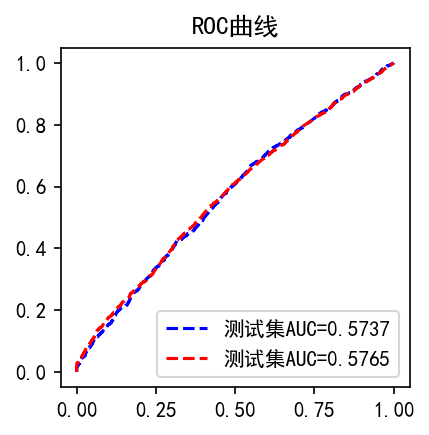

In [20]:
fpr_test,tpr_test,th_test = metrics.roc_curve(test.is_ovd,test.pre1) # 测试集
fpr_train,tpr_train,th_train = metrics.roc_curve(train.is_ovd,train.pre1) # 训练集
plt.figure(dpi=150,figsize=(3,3))
plt.plot(fpr_test,tpr_test,'b--',label=f'测试集AUC={round(metrics.auc(fpr_test,tpr_test),4)}')
plt.plot(fpr_train,tpr_train,'r--',label=f'测试集AUC={round(metrics.auc(fpr_train,tpr_train),4)}')
plt.legend();plt.title('ROC曲线')

#### 加入信用局评分

In [31]:
x = data.loc[:,'CODE_GENDER_F':]
# x.drop(columns=['OCCUPATION_TYPE_1','OCCUPATION_TYPE_2','OCCUPATION_TYPE_3','OCCUPATION_TYPE_4','OCCUPATION_TYPE_5','OCCUPATION_TYPE_6','OCCUPATION_TYPE_7'],inplace=True)
x.drop(columns=['NAME_EDUCATION_TYPE_1','OCCUPATION_TYPE_6','OCCUPATION_TYPE_3','OCCUPATION_TYPE_5','FLAG_EMAIL_Y'],inplace=True)
y = data['is_ovd']
# 训练：测试=7:3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=0)
lr = sma.Logit(y_train,x_train)
result = lr.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.078840
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                Logit             Pseudo R-squared:  0.054     
Dependent Variable:   is_ovd            AIC:               27365.8409
Date:                 2020-08-11 21:47  BIC:               27607.3404
No. Observations:     173248            Log-Likelihood:    -13659.   
Df Model:             23                LL-Null:           -14442.   
Df Residuals:         173224            LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       9.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
CODE_GENDER_F        -0.4441   0.0448  -9.9052 0.0000 -0.5320 -0.3562
FLAG_OWN_REALTY_Y    -0.2330   0.0396  -5.8807 0.0000 -0.3106 -0.1553
AMT_INCOME_TOTAL_1    0.5121   0.0668   7.6679 0.0000  0.3812  0.6430
AMT_INCOME_TOTAL_2    0.2574   0.0561   4.5864 0.0000  0.1474  0.3674
AMT_INCOME_TOTAL_3    0.2387   0.0576   4.1405 0.0000  0.1257  0.3517
NAME_INCOME_TYPE_1    7.3512   0.6033  12.1849 0.0000  6.1687  8.5336
NAME_INCOME_TYPE_2   -0.1740   0.0663  -2.6231 0.0087 -0.3041 -0.0440
NAME_INCOME_TYPE_3   -0.2673   0.0732  -3.6508 0.0003 -0.4109 -0.1238
NAME_FAMILY_STATUS_1  0.4002   0.0514   7.7930 0.0000  0.2996  0.5009
NAME_FAMILY_STATUS_2  0.2640   0.0796   3.3148 0.0009  0.1079  0.4201
NAME_FAMILY_STATUS_3  0.2202   0.0701   3.1402 0.0017  0.0828  0.3576
AGE_1                -0.2495   0.0515  -4.8433 0.0000 -0.3505 -0.1486
AGE_2                -0.4350   0.0551  -7.8923 0.0000 -0.5430 -0.3270
OCCUPATION_TYPE_1    -0.1260   0.0835  -1.5096 0.1312 -0.2896  0.0376
OCCUPATION_TYPE_2    -0.1238   0.0573  -2.1621 0.0306 -0.2361 -0.0116
OCCUPATION_TYPE_4    -0.1249   0.0725  -1.7240 0.0847 -0.2670  0.0171
OCCUPATION_TYPE_7    -0.1494   0.0627  -2.3812 0.0173 -0.2723 -0.0264
CNT_FAM_MEMBERS_1    -1.0443   0.0879 -11.8784 0.0000 -1.2166 -0.8720
CNT_FAM_MEMBERS_2    -1.0566   0.0969 -10.9097 0.0000 -1.2464 -0.8668
CNT_FAM_MEMBERS_3    -1.0018   0.1093  -9.1690 0.0000 -1.2159 -0.7877
WORK_TIME_1          -7.8602   0.6064 -12.9629 0.0000 -9.0487 -6.6718
WORK_TIME_2          -0.2263   0.0558  -4.0553 0.0001 -0.3357 -0.1169
WORK_TIME_3          -0.4091   0.0602  -6.7938 0.0000 -0.5271 -0.2911
credit_score         -0.0042   0.0001 -33.7714 0.0000 -0.0044 -0.0039
=====================================================================

"""

Text(0.5, 1.0, 'ROC曲线')

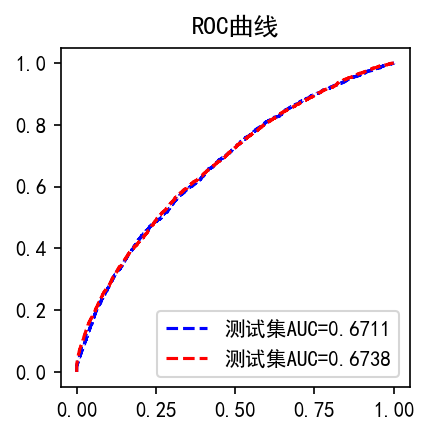

In [32]:
test = pd.DataFrame()
test['pre1'] = result.predict(x_test)
test['pre2'] = test['pre1'].apply(lambda x: round(x))
test['is_ovd'] = y_test
train = pd.DataFrame()
train['pre1'] = result.predict(x_train)
train['pre2'] = train['pre1'].apply(lambda x: round(x))
train['is_ovd'] = y_train
fpr_test,tpr_test,th_test = metrics.roc_curve(test.is_ovd,test.pre1) # 测试集
fpr_train,tpr_train,th_train = metrics.roc_curve(train.is_ovd,train.pre1) # 训练集
plt.figure(dpi=150,figsize=(3,3))
plt.plot(fpr_test,tpr_test,'b--',label=f'测试集AUC={round(metrics.auc(fpr_test,tpr_test),4)}')
plt.plot(fpr_train,tpr_train,'r--',label=f'测试集AUC={round(metrics.auc(fpr_train,tpr_train),4)}')
plt.legend();plt.title('ROC曲线')

# task6代码.ipynb

In [91]:
x = data.loc[:,'CODE_GENDER_F':]
# x.drop(columns=['OCCUPATION_TYPE_1','OCCUPATION_TYPE_2','OCCUPATION_TYPE_3','OCCUPATION_TYPE_4','OCCUPATION_TYPE_5','OCCUPATION_TYPE_6','OCCUPATION_TYPE_7'],inplace=True)
x.drop(columns=['NAME_EDUCATION_TYPE_1','OCCUPATION_TYPE_6','OCCUPATION_TYPE_3','OCCUPATION_TYPE_5','FLAG_EMAIL_Y'],inplace=True)
y = data['is_ovd']
# 训练：测试=7:3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=3)
lr = sma.Logit(y_train,x_train)
result = lr.fit()

Optimization terminated successfully.
         Current function value: 0.080088
         Iterations 9


#### 将概率转化成分数且为正整数

In [92]:
# 评分卡刻度 A、B
def cal_scale(score,odds,PDO):
    '''
    参数：
        odds: 设定的坏好比
        score: 在这个odds下的分数
        PDO： 好坏翻倍比
        model: 逻辑回归模型
    return：
        A,B
    '''
    B = PDO/np.log(2)
    A = score + B*np.log(odds)
    # base_score = A+B*model.intercept_[0]
    print('B: {:.2f}'.format(B))
    print('A: {:.2f}'.format(A))
    # print('基础分为：{:.2f}'.format(base_score))
    return A,B

In [93]:
def Pre2Score(pre,A,B):
    y = np.log(pre/(1-pre))
    return round(A-B*y)

In [94]:
A,B = cal_scale(525,0.05,10) # 假设基础分为50，odds为5%，PDO为10

B: 14.43
A: 481.78


Text(0, 0.5, '频数')

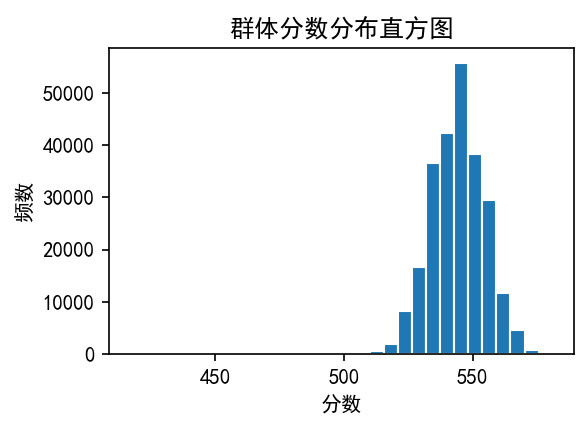

In [95]:
all_cust = pd.DataFrame({'pre':result.predict(x),'is_ovd':y})
all_cust['score'] = all_cust['pre'].map(lambda x:Pre2Score(x,A,B))
# 直方图
plt.figure(dpi=150,figsize=(4,2.7))
plt.hist(all_cust['score'].values,edgecolor='w',bins=30)
plt.title('群体分数分布直方图');plt.xlabel('分数');plt.ylabel('频数')

In [96]:
all_cust['score'].describe()

count    247498.000000
mean        544.214947
std          10.504158
min         417.000000
25%         537.000000
50%         544.000000
75%         551.000000
max         581.000000
Name: score, dtype: float64

In [97]:
train = pd.DataFrame({'pre':result.predict(x_train),'is_ovd':y_train})
train['score'] = train['pre'].map(lambda x:Pre2Score(x,A,B))
train['score'].describe()

count    173248.000000
mean        544.234260
std          10.494716
min         417.000000
25%         537.000000
50%         544.000000
75%         551.000000
max         581.000000
Name: score, dtype: float64

In [98]:
test = pd.DataFrame({'pre':result.predict(x_test),'is_ovd':y_test})
test['score'] = test['pre'].map(lambda x:Pre2Score(x,A,B))
test['score'].describe()

count    74250.000000
mean       544.169886
std         10.526090
min        419.000000
25%        537.000000
50%        544.000000
75%        551.000000
max        579.000000
Name: score, dtype: float64

#### 模型分数稳定性监控表

In [130]:
model = pd.DataFrame(columns = ['分数','建模样本数','百分比1','评分样本数','百分比2','ln(百分比比例)','百分比变化','IV值'])

for i in [[400,450],[450,500],[500,525],[525,550],[550,575],[575,600]]:
    model = model.append([{'建模样本数':train['score'].isin(range(i[0],i[1])).agg(sum),'评分样本数':test['score'].isin(range(i[0],i[1])).agg(sum)}])

model['分数'] = ['400-450','450-500','500-525','525-550','550-575','575-600']
model['百分比1'] = model['建模样本数']/len(train)
model['百分比2'] = model['评分样本数']/len(test)
model['ln(百分比比例)'] = (model['百分比2']/model['百分比1']).apply(lambda x: np.log(x))
model['百分比变化'] = (model['百分比2'] - model['百分比1'])
model.set_index('分数',inplace=True)
model.loc['合计'] = model.agg(sum)
# 格式化
model['IV值'] = (model['百分比变化'] * model['ln(百分比比例)']).apply(lambda x:round(x,4))
model['百分比1'] = model['百分比1'].apply(lambda x: format(x,'.2%'))
model['百分比2'] = model['百分比2'].apply(lambda x: format(x,'.2%'))
model['ln(百分比比例)'] = model['ln(百分比比例)'].apply(lambda x: round(x,3))
model['百分比变化'] = model['百分比变化'].apply(lambda x: format(x,'.2%'))
model

,建模样本数,百分比1,评分样本数,百分比2,ln(百分比比例),百分比变化,IV值
分数,,,,,,,
400-450,56,0.03%,27,0.04%,0.118,0.00%,0.0000
450-500,8,0.00%,8,0.01%,0.847,0.01%,0.0001
500-525,4864,2.81%,2091,2.82%,0.003,0.01%,0.0000
525-550,114578,66.14%,49275,66.36%,0.003,0.23%,0.0000
550-575,53638,30.96%,22793,30.70%,-0.009,-0.26%,0.0000
575-600,104,0.06%,56,0.08%,0.228,0.02%,0.0000
合计,173248,100.00%,74250,100.00%,1.191,0.00%,0.0000


#### 模型预测能力监控报表

In [332]:
model2 = pd.DataFrame(columns=['细分单元','最高分','最低分','建模样本坏客户率','评分样本坏客户率'])

for i in [[400,450],[450,500],[500,525],[525,550],[550,575],[575,600]]:
    a = train[train['score'].isin(range(i[0],i[1]))]
    b = test[test['score'].isin(range(i[0],i[1]))]
    model2 = model2.append([{'最高分':max(max(a['score']),max(b['score'])), '最低分':min(min(a['score']),min(b['score'])),
                            '建模样本坏客户率':format(a[a.is_ovd == 1]['score'].count()/len(a),'.2%'),
                            '评分样本坏客户率':format(b[b.is_ovd == 1]['score'].count()/len(b),'.2%')}])
model2['细分单元'] = range(1,len(model))
model2.set_index('细分单元')

,最高分,最低分,建模样本坏客户率,评分样本坏客户率
细分单元,,,,
1,449.0,417.0,94.64%,100.00%
2,499.0,450.0,87.50%,87.50%
3,524.0,500.0,5.63%,5.74%
4,549.0,525.0,1.87%,1.76%
5,574.0,550.0,0.74%,0.75%
6,581.0,575.0,0.96%,0.00%


#### 模型变量预测能力监控表

In [325]:
writer = pd.ExcelWriter('../task6/模型变量预测能力监控报表2.xlsx'); row = 0
for i in [['CODE_GENDER','性别'],['FLAG_OWN_REALTY','是否有房产'],['NAME_INCOME_TYPE','收入类型'],['NAME_FAMILY_STATUS','婚姻状况'],['OCCUPATION_TYPE','职业'],
          ['AMT_INCOME_TOTAL','年收入'],['AGE','年龄'],['CNT_FAM_MEMBERS','家庭人数'],['WORK_TIME','工作年限']]:
    a  = pd.Series(x.columns); a[a.str.contains(i[0])]
    df = pd.DataFrame(columns=[i[1],'建模样本数','建模坏客户数','建模坏客户率','评分样本数','评分坏客户数','评分坏客户率'])
    a  = pd.Series(x.columns); b = a[a.str.contains(i[0])]
    df = pd.DataFrame(columns=[i[1],'建模样本数','建模坏客户数','评分样本数','评分坏客户数'])
    
    for j in b:
        df = df.append([{'建模样本数':(x_train[j]==1).agg(sum), '建模坏客户数':y_train[x_train[j]==1].agg(sum), 
                         '评分样本数':(x_test[j]==1).agg(sum), '评分坏客户数':y_test[x_test[j]==1].agg(sum)}])
        
    df[i[1]] = b.values;df.set_index(i[1],inplace=True); 
    df.loc['其他'] = np.array([len(x_train),y_train.agg(sum),len(x_test),y_test.agg(sum)]) - np.array(df.apply(lambda x:sum(x)))
    df.loc['合计'] = df.apply(lambda x:sum(x))
    df.insert(2,'建模坏客户率',(df['建模坏客户数']/df['建模样本数']).apply(lambda x:format(x,'.2%')))
    df['评分坏客户率'] = (df['评分坏客户数']/df['评分样本数']).apply(lambda x:format(x,'.2%'))
    # df.columns=['建模样本数','建模坏客户数','建模坏客户率','评分样本数','评分坏客户数','评分坏客户率']
    df.to_excel(writer,startrow=row)
    row = row + len(df) + 2
writer.save()